# Libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import os

# Clean data

In [2]:
def change_column_names(df):
    columns = {
        "latitude": "latitude", "longitude": "longitude", "population_density": "population_density", "General class": "land_cover_type",
        "class": "land_cover_subtype", "Sub-class": "vegetation_percent", "date": "date", "ws": "wind_speed", "vpd": "vapor_pressure_deficit",
        "vap": "vapor_pressure", "tmin": "minimum_temperature", "tmax": "maximum_temperature", "swe": "snow_water_equivalent",
        "srad": "surface_shortwave_radiation", "soil": "soil_moisture", "q": "runoff", "ppt": "precipitation_accumulation",
        "pet": "Reference_evapotranspiration", "def": "climate_water_deficit", "aet": "actual_Evapotranspiration",
        "PDSI": "palmer_drought_severity_index", "brightness": "brightness_temperature", "scan": "scan_fire_size", "track": "track_fire_size",
        "confidence": "confidence", "frp": "fire_radiative_power", "daynight": "daynight", "type": "fire_type", "n_pixels": "n_pixels_ndvi",
        "vim": "ndvi", "vim_avg": "ndvi_long_term_average", "viq": "ndvi_anomaly_percent", "dem": "dem"
    }

    return df.dropna().rename(columns=columns)[columns.values()]

def get_confidence_indexes(df, target, min_value, max_value):
    df[target] = df[target].astype(int)
    target_values = df[(min_value <= df[target]) & (df[target] <= max_value)][target]
    return target_values.index.to_numpy()

def clear_confidence(df, target):
    df_temp = df[(df[target] != 'h') & (df[target] != 'n') & (df[target] != 'l')]
    df_temp_copy = df_temp.copy()
    range_values = {
        'l': (0, 29),
        'n': (30, 79),
        'h': (80, 100)
    }

    for key, (min_value, max_value) in range_values.items():
        indexes = get_confidence_indexes(df_temp_copy, target, min_value, max_value)
        df_temp.loc[indexes, target] = key

    values = df_temp[target].to_numpy()
    indexes = df_temp[target].index.to_numpy()

    return values, indexes

def clean_dtypes(df, target_name):
    columns = df.drop(columns=[target_name]).select_dtypes(exclude=['number']).columns
    df[target_name] = df[target_name].astype(str)
    dict_values = {}

    for column_name in columns:
        nor_values = df[column_name].values
        cat_values = df[column_name].astype('category').cat.codes
        dict_values[column_name] = {f"{value[0]}":value[1] for value in set(zip(nor_values, cat_values))}
        df[column_name] = cat_values

    return df, dict_values

def set_season(date_value):
    if 3 <= date_value.month <= 5 or 9 <= date_value.month <= 11:
        return "rainy season"
    return "dry season"

def clean_dates(df_final):
    df_final = change_column_names(df_final)
    df_final['seasons'] = df_final['date'].apply(set_season)
    # df_final['days'] = (df_final['date'] - df_final['date'].min()).dt.days.astype(int)
    df_final = df_final.drop(columns=['date'])

    return df_final

def get_general_dataframe(df_values, target):
    df = clean_dates(df_values.copy())
    df, dict_values = clean_dtypes(df.copy(), target)

    values, indexes = clear_confidence(df.copy(), target)
    for index, value in zip(indexes, values):
        df.loc[index, target] = value

    return df, dict_values

# models

In [29]:
def get_models_path():
    models_path = "../models"

    if not os.path.exists(models_path):
        os.makedirs(models_path)

    return models_path

def get_train_test_values(df, target):
    X = df.drop(columns=[target]).values
    y = df[target].values

    return train_test_split(X, y, test_size=0.2, random_state=42)

def get_bayesian_model(train_test_values):
    X_train, X_test, y_train, y_test = train_test_values
    model = BernoulliNB()

    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)

    return model, score

def get_random_forest_classifier_model(train_test_values):
    X_train, X_test, y_train, y_test = train_test_values
    model = RandomForestClassifier(n_estimators=120, max_depth=10, random_state=42)

    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)

    return model, score

def create_models(df, target):
    train_test_values = get_train_test_values(df, target)
    random_forest_model, random_forest_score = get_random_forest_classifier_model(train_test_values)
    bayesian_model, bayesian_score = get_bayesian_model(train_test_values)

    return random_forest_model, random_forest_score, bayesian_model, bayesian_score

def save_model(dict_values, model, models_path):
    joblib.dump(model, f"{models_path}/model.joblib")
    joblib.dump(dict_values, f"{models_path}/dict_values.joblib")

# Reading data from drive

In [7]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
drive_path = "/content/drive/MyDrive"

In [9]:
root_directory_drive_path = f"{drive_path}/datasets"
df_final = pd.read_pickle(f'{root_directory_drive_path}/final_dataset.pkl')

In [28]:
root_directory_path = "../datasets"
df_final.to_pickle(f'{root_directory_path}/final_dataset.pkl')

# Describing data

In [30]:
root_directory_path = "../datasets"
models_path = get_models_path()

In [14]:
df_final = pd.read_pickle(f'{root_directory_path}/final_dataset.pkl')

In [13]:
target = "confidence"

In [15]:
df_final_cleanned, dict_values = get_general_dataframe(df_final.copy(), target)
df_final_cleanned_codes = df_final_cleanned.apply(lambda x: pd.Categorical(x).codes)

In [16]:
df_final_cleanned_codes.describe().applymap(lambda x: '{:.2f}'.format(x))

,latitude,longitude,population_density,land_cover_type,land_cover_subtype,vegetation_percent,wind_speed,vapor_pressure_deficit,vapor_pressure,minimum_temperature,...,confidence,fire_radiative_power,daynight,fire_type,n_pixels_ndvi,ndvi,ndvi_long_term_average,ndvi_anomaly_percent,dem,seasons
count,1830929.00,1830929.00,1830929.00,1830929.00,1830929.00,1830929.00,1830929.00,1830929.00,1830929.00,1830929.00,...,1830929.00,1830929.00,1830929.00,1830929.00,1830929.00,1830929.00,1830929.00,1830929.00,1830929.00,1830929.00
mean,615099.40,382105.84,517082.34,5.86,5.81,25.82,142.11,134.04,2061.85,2166.01,...,1.72,1618.14,0.16,2.93,76.11,3235.25,1913.37,36236.86,39.72,0.40
std,351789.19,209347.30,288673.23,1.27,4.05,23.21,87.71,43.55,308.68,263.69,...,0.66,2299.75,0.36,0.33,46.42,1201.55,1041.61,19260.22,30.37,0.49
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,319849.00,208187.00,276043.00,6.00,2.00,0.00,77.00,101.00,1954.00,2122.00,...,2.00,419.00,0.00,3.00,28.00,2273.00,947.00,21937.00,12.00,0.00
50%,604931.00,371019.00,509711.00,6.00,3.00,25.00,122.00,129.00,2100.00,2222.00,...,2.00,807.00,0.00,3.00,92.00,3539.00,2177.00,36110.00,31.00,0.00
75%,906865.00,557734.00,769354.00,6.00,10.00,53.00,184.00,166.00,2243.00,2296.00,...,2.00,1754.00,0.00,3.00,118.00,4195.00,2705.00,49692.00,66.00,1.00
max,1256814.00,791198.00,1004001.00,7.00,11.00,61.00,594.00,288.00,2724.00,2592.00,...,2.00,18538.00,1.00,3.00,135.00,5237.00,3705.00,76826.00,98.00,1.00


In [17]:
df_final_cleanned.columns

Index(['latitude', 'longitude', 'population_density', 'land_cover_type',
       'land_cover_subtype', 'vegetation_percent', 'wind_speed',
       'vapor_pressure_deficit', 'vapor_pressure', 'minimum_temperature',
       'maximum_temperature', 'snow_water_equivalent',
       'surface_shortwave_radiation', 'soil_moisture', 'runoff',
       'precipitation_accumulation', 'Reference_evapotranspiration',
       'climate_water_deficit', 'actual_Evapotranspiration',
       'palmer_drought_severity_index', 'brightness_temperature',
       'scan_fire_size', 'track_fire_size', 'confidence',
       'fire_radiative_power', 'daynight', 'fire_type', 'n_pixels_ndvi',
       'ndvi', 'ndvi_long_term_average', 'ndvi_anomaly_percent', 'dem',
       'seasons'],
      dtype='object')

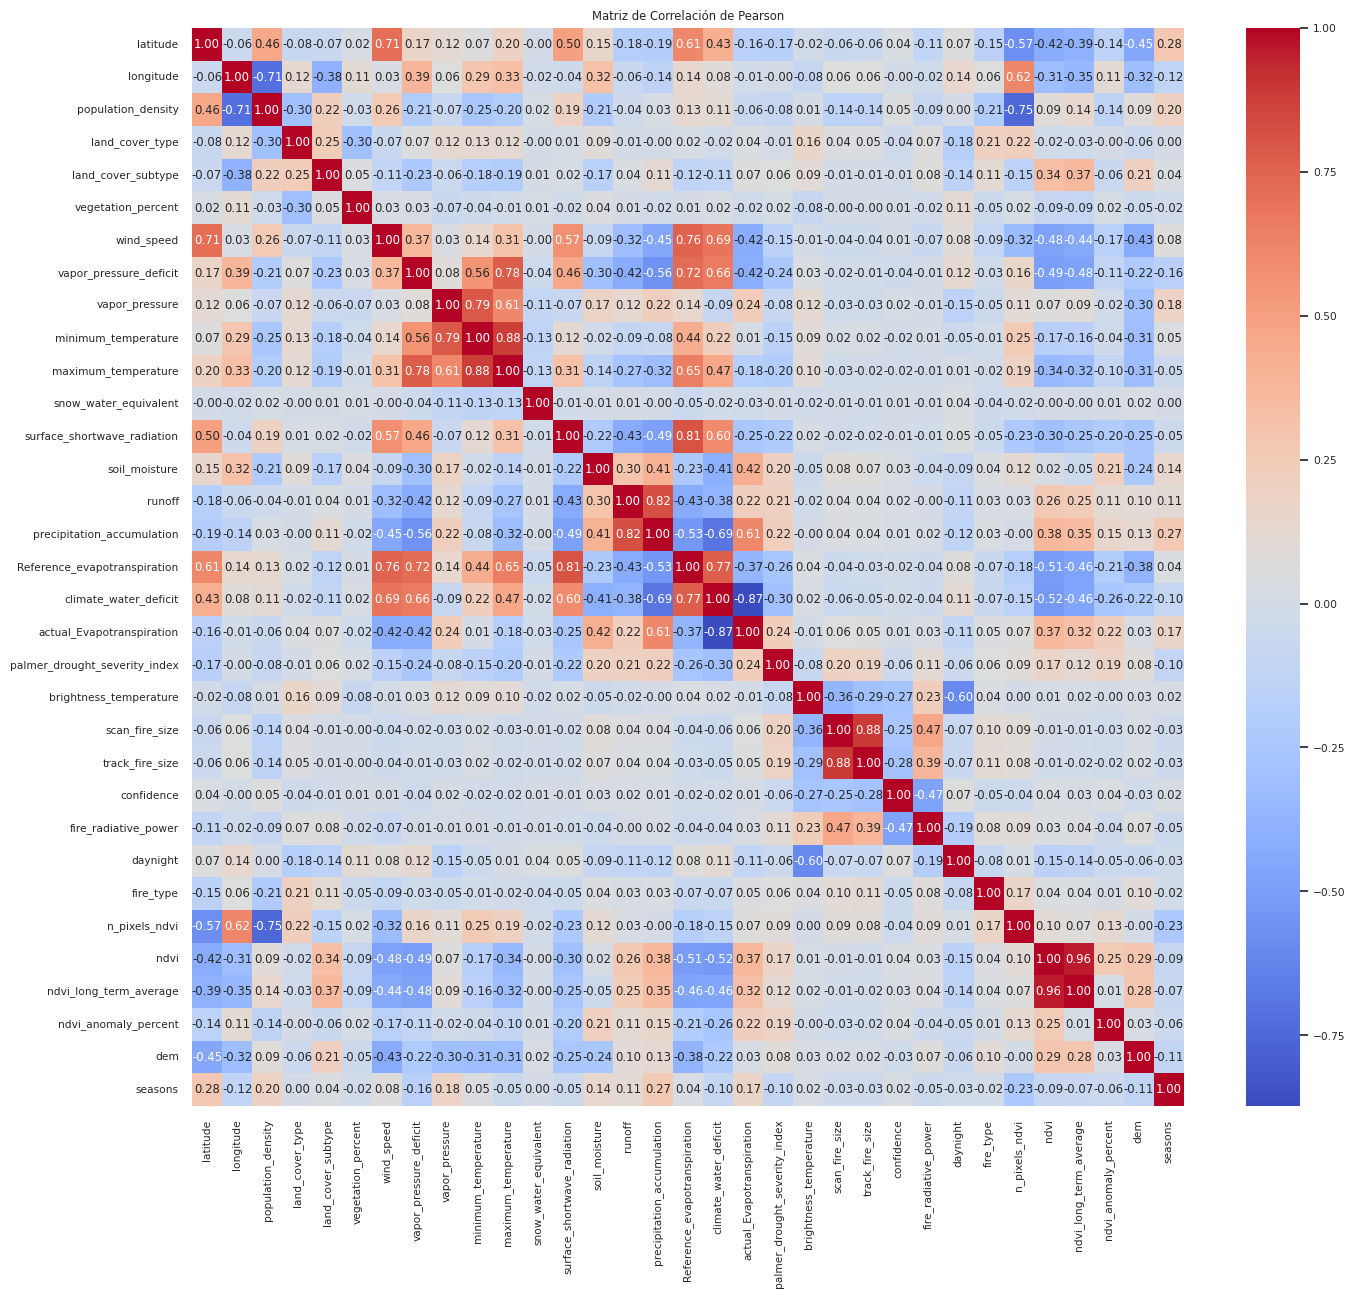

In [18]:
corr = df_final_cleanned_codes.corr()
plt.figure(figsize=(16, 14))
sns.set(font_scale=0.7)

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Pearson')
plt.show()

# Creating model

In [19]:
random_forest_model, random_forest_score, bayesian_model, bayesian_score = create_models(df_final_cleanned, target)

In [20]:
print(f"random_forest_score={random_forest_score}")
print(f"bayesian_score={bayesian_score}")

random_forest_score=0.9218156892945115
bayesian_score=0.8311022267372319


In [21]:
model = random_forest_model if random_forest_score >= bayesian_score else bayesian_model

In [22]:
save_model(dict_values, model, models_path)

# Data to drive

In [23]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
drive_path = "/content/drive/MyDrive"

In [25]:
models_drive_path = f"{drive_path}/models"

if not os.path.exists(models_drive_path):
    os.makedirs(models_drive_path)

In [26]:
def save_model_to_drive(models_path, models_drive_path):
    model = joblib.load(f"{models_path}/model.joblib")
    dict_values = joblib.load(f"{models_path}/dict_values.joblib")

    joblib.dump(model, f"{models_drive_path}/model.joblib")
    joblib.dump(dict_values, f"{models_drive_path}/dict_values.joblib")

In [27]:
save_model_to_drive(models_path, models_drive_path)